IMPORT

In [1]:
import matplotlib.pyplot as plt
import os
import re
from glob import glob
import numpy as np
import cv2
import dlib
import datetime as dt
import pandas as pd

Load File

In [2]:
subject_name = '01-01'
dataset_path = 'PURE/'

img_frame_path = dataset_path + subject_name + '/01-01/'

png_list = glob(img_frame_path + '*.png')
png_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
# print(f"First 10 frames: {png_list[:10]}")S
print(f"Length: {len(png_list)}")

Length: 2026


Global Variabel

In [3]:
idx_frame_start = 0
idx_frame_end = len(png_list) - 1
fps = 30
n_segment = 2
left_expand_ratio = 0.25
top_expand_ratio = 0.25

f_cnt = 0
i_cnt = idx_frame_start

In [4]:
detector = dlib.get_frontal_face_detector() # Face detection

In [5]:
face_left, face_top, face_right, face_bottom = 0,0,0,0
mask = None
n_skinpixels = 0

In [6]:
while(i_cnt >= idx_frame_start and i_cnt <= idx_frame_end):

    frame = cv2.imread(png_list[i_cnt])
    h, w, _ = frame.shape

    # frame_toshow = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)
    # print(f"Height: {h}, WidthL {w}")

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #apply face detection
    if f_cnt == 0:
        rect = detector(gray_frame, 0)
        rect = rect[0]
        left, right, top, bottom = rect.left(), rect.right(), rect.top(), rect.bottom()

        width = abs (right - left)
        height = abs (bottom - top)
        face_left = int(left - (left_expand_ratio/2 * width))
        face_top = int (top - (top_expand_ratio/2 * height ))
        face_right = right
        face_bottom = bottom

    face = frame[face_top:face_bottom, face_left:face_right]

    # frame_toshow = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)

    # Convert the face region to YCrCb color space
    face_YCrCb = cv2.cvtColor(face, cv2.COLOR_BGR2YCrCb)

    # Define the skin color range in YCrCb
    lower_skin = np.array([0, 133, 77], dtype=np.uint8)
    upper_skin = np.array([255, 173, 127], dtype=np.uint8)

    # Create a binary mask where skin color is white and the rest is black
    mask = cv2.inRange(face_YCrCb, lower_skin, upper_skin)
    n_skinpixels = np.sum(mask)

    # Apply the mask to the face region
    masked_face = cv2.bitwise_and(face, face, mask=mask)

    # frame_toshow= cv2.cvtColor(masked_face, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)

    #Get the mean RGB value in the skin
    mean_r = np.sum(masked_face[:,:,2]) / n_skinpixels
    mean_g = np.sum(masked_face[:,:,1]) / n_skinpixels
    mean_b = np.sum(masked_face[:,:,0]) / n_skinpixels

    if f_cnt ==0:
        mean_rgb = np.array([mean_r, mean_g, mean_b])
    else:
        mean_rgb = np.vstack((mean_rgb,np.array([mean_r, mean_g, mean_b])))

    # break

    f_cnt += 1
    i_cnt += 1


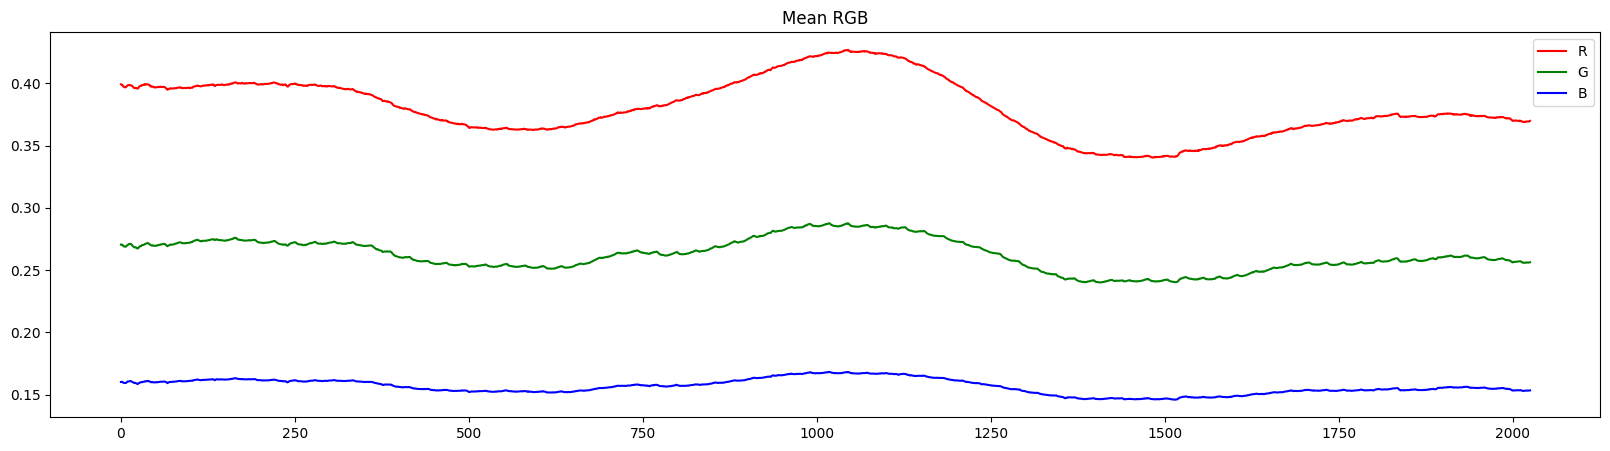

In [7]:
plt.figure(figsize=(20,5))
plt.plot(mean_rgb[:,0], label = 'R', color='red')
plt.plot(mean_rgb[:,1], label = 'G', color='green')
plt.plot(mean_rgb[:,2], label = 'B', color='blue')
plt.legend()
plt.title("Mean RGB")
plt.show()

POS

In [8]:
l = int(fps * 1.6)
print(f"Window length: {l}")
rPPG_signals = np.zeros(mean_rgb.shape[0])
print(f"rPPG_signals shape: {rPPG_signals.shape}")

Window length: 48
rPPG_signals shape: (2026,)


In [9]:
for t in range (0, mean_rgb.shape[0] - l):

    ## CREATE C DATA
    C = mean_rgb[t:t+l-1,:].T

    # print(f"C shape: {C.shape}")
    # print (f"C: \n{C}")

    ## CREATE TEMPORAL NORMALIZATION

    mean_color = np.mean(C, axis=1)

    # print(f"Shape of mean color: {mean_color.shape}")
    # print(f"Mean Color: {mean_color}")

    diag_mean_color = np.diag(mean_color)

    # print(f"Shape of diag mean color: {diag_mean_color.shape}")
    # print(f"Diag Mean Color: \n{diag_mean_color}")

    diag_mean_color_inv = np.linalg.inv(diag_mean_color)
    # print(f"Shape of diag mean color inv: {diag_mean_color_inv.shape}")
    # print(f"Diag Mean Color Inv: \n{diag_mean_color_inv}")

    Cn = np.matmul(diag_mean_color_inv, C)
    # print(f"Cn Shape: {Cn.shape}")



    ##FROM 3D TO 2D

    projection_matrix = np.array([[0, 1, -1], [-2, 1, 1]]) 

    S= np.matmul(projection_matrix, Cn)
    # print(f"Shape of S: {S.shape}")

    ##FROM 2D TO 1D

    std = np.array([1, np.std(S[0,:]) / np.std(S[1,:])])
    # print(f"Shape of std: {std.shape}")
    # print(f"std: {std}")

    P = np.matmul(std, S)
    # print(f"Shape of P: {P.shape}")

    # plt.figure(figsize=(20,5))
    # plt.plot(P)

    ## OVERLAPPING

    epsilon = 1e-8  # Small value to avoid division by zero
    rPPG_signals[t:t+l-1] = rPPG_signals[t:t+l-1] + (P - np.mean(P)) / (np.std(P) + epsilon)



    # break



GRGB

In [10]:
R = mean_rgb[:, 0]
G = mean_rgb[:, 1]
B = mean_rgb[:, 2]

GRGB_signal = (G/R) + (G/B)

# GRGB_signal.shape

Converting Timestamps

In [11]:
timestamps = []

for file_name in png_list:
    # Use regex to extract digits following 'Image' and before '.png'
    match = re.search(r'Image(\d+)\.png', file_name)
    if match:
        timestamps.append(match.group(1))

# print(len(timestamps))

formatted_times = []
for ts in timestamps:
    # Convert nanoseconds to seconds
    timestamp_sec = int(ts) / 1e9
    
    # Create a datetime object for the integer part of the timestamp
    time = dt.datetime.fromtimestamp(timestamp_sec)
    
    # Get the fractional seconds (2 decimal places)
    fractional_sec = f"{timestamp_sec % 60:.2f}"
    
    # Combine the minute and second part from the datetime object with fractional seconds
    formatted_time = time.strftime("%M:%S") + fractional_sec[2:]  # Skip leading '0' in fractional seconds
    formatted_times.append(formatted_time)

formatted_times = sorted(formatted_times)
# Print formatted times and original timestamps
# print(len(formatted_times))
# print(formatted_times[:5])
# print(timestamps[:5])

Shape of rPPG_signals: (2026,)


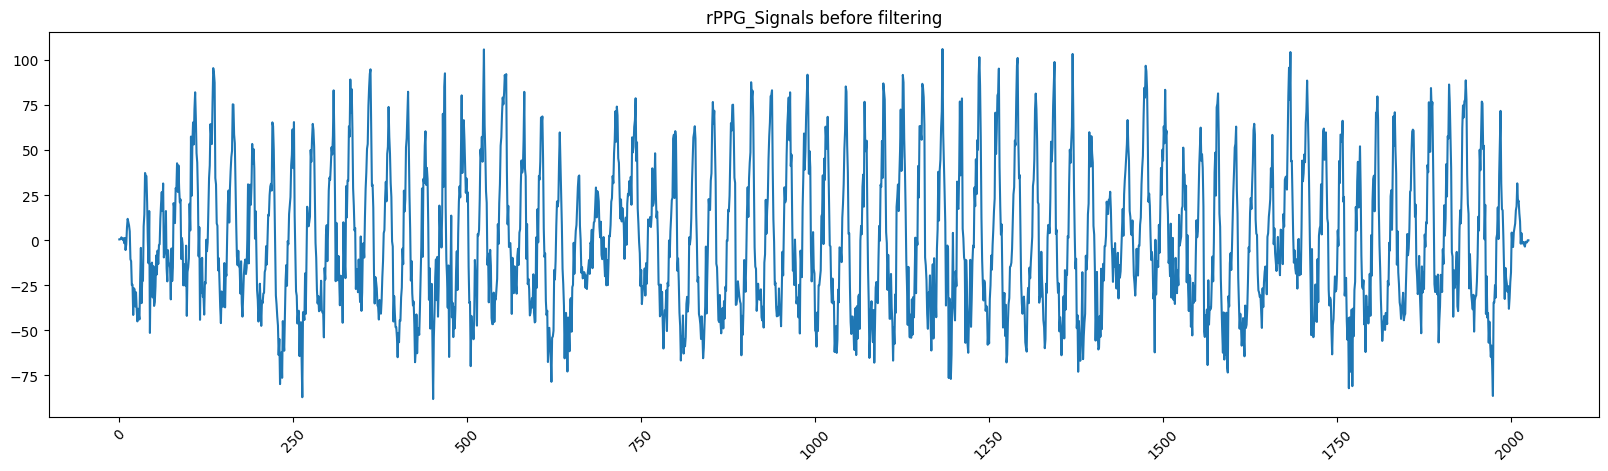

In [12]:
from matplotlib.ticker import MaxNLocator


print(f"Shape of rPPG_signals: {rPPG_signals.shape}")
plt.figure(figsize=(20,5))
# plt.plot(formatted_times, rPPG_signals)
plt.plot(rPPG_signals)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability

plt.title(f"rPPG_Signals before filtering")
plt.show()

Shape of GRGB_signals: (2026,)


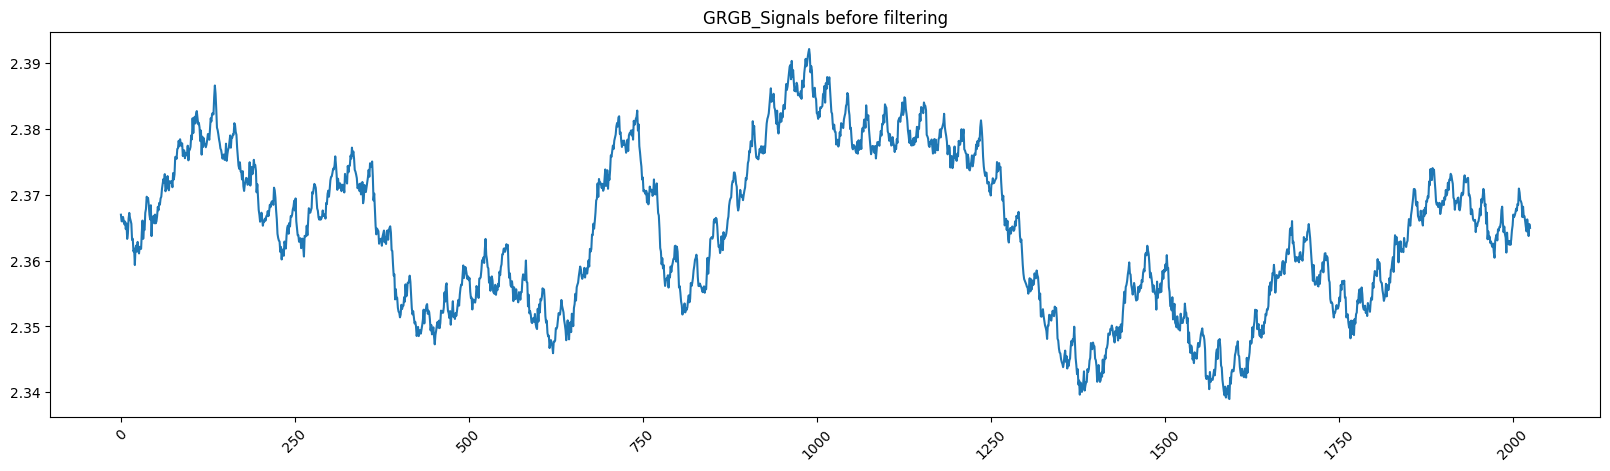

In [13]:
from matplotlib.ticker import MaxNLocator


print(f"Shape of GRGB_signals: {GRGB_signal.shape}")
plt.figure(figsize=(20,5))
# plt.plot(formatted_times, GRGB_signal)
plt.plot(GRGB_signal)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability

plt.title(f"GRGB_Signals before filtering")
plt.show()

Shape of rPPG_signals: (2026,)
[ 0.02868064  0.07354457  0.12211303 ... -0.14690821 -0.09779515
 -0.03852532]


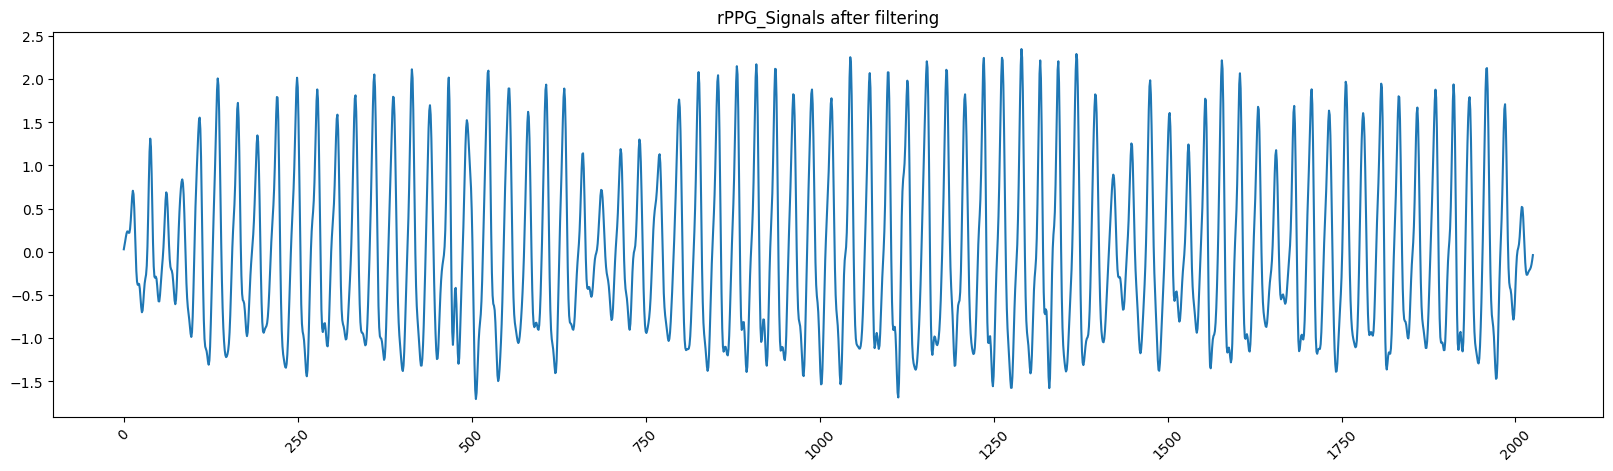

In [14]:
from scipy import signal

lowcut = 0.65
highcut = 4

b, a = signal.butter(6, [lowcut, highcut], btype='bandpass', fs=fps)
rPPG_filtered = signal.filtfilt(b, a, rPPG_signals)

#standardization
rPPG_filtered = (rPPG_filtered-np.mean(rPPG_filtered))/np.std(rPPG_filtered)

print(f"Shape of rPPG_signals: {rPPG_filtered.shape}")
print(rPPG_filtered)
plt.figure(figsize=(20,5))
# plt.plot(formatted_times, rPPG_filtered)
plt.plot(rPPG_filtered)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.title(f"rPPG_Signals after filtering")
plt.show()

Shape of GRGB_signals: (2026,)
[ 0.02635762  0.01228086  0.04001426 ... -0.61474346 -0.4288773
 -0.20514645]


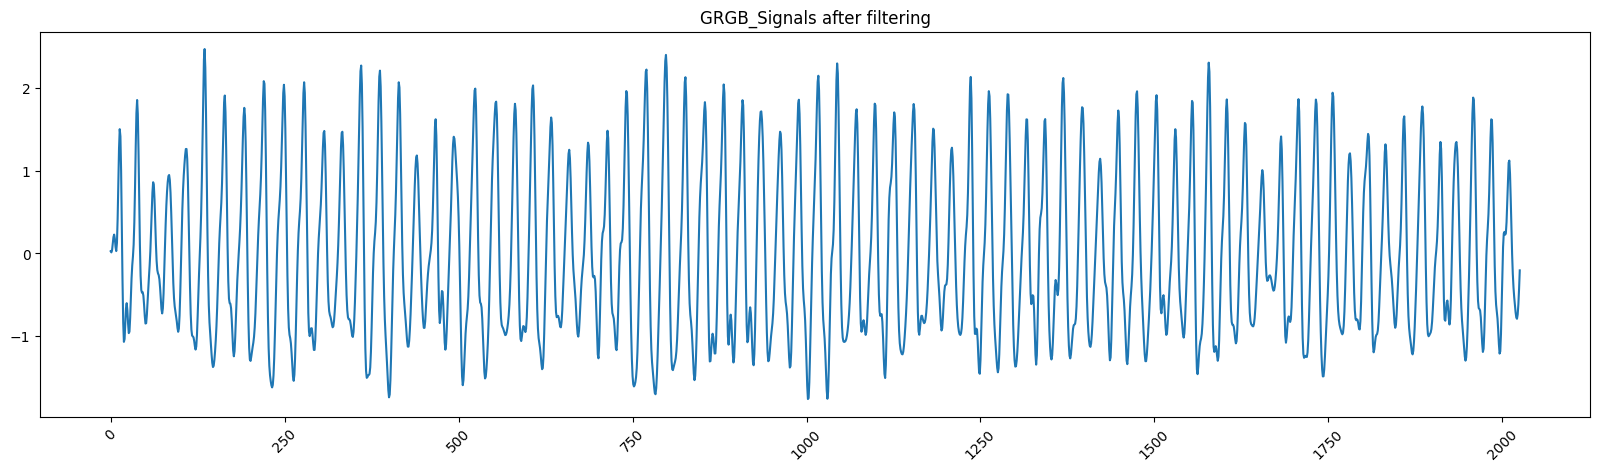

In [15]:
from scipy import signal

lowcut = 0.65
highcut = 4

b, a = signal.butter(6, [lowcut, highcut], btype='bandpass', fs=fps)
GRGB_filtered = signal.filtfilt(b, a, GRGB_signal)

#standardization
GRGB_filtered = (GRGB_filtered-np.mean(GRGB_filtered))/np.std(GRGB_filtered)

print(f"Shape of GRGB_signals: {GRGB_filtered.shape}")
print(GRGB_filtered)
plt.figure(figsize=(20,5))
# plt.plot(formatted_times, GRGB_filtered)
plt.plot(GRGB_filtered)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.title(f"GRGB_Signals after filtering")
plt.show()

Compare with groundtruth

[1392643993646759000, 1392643993678766000, 1392643993694760000, 1392643993710761000, 1392643993726757000]


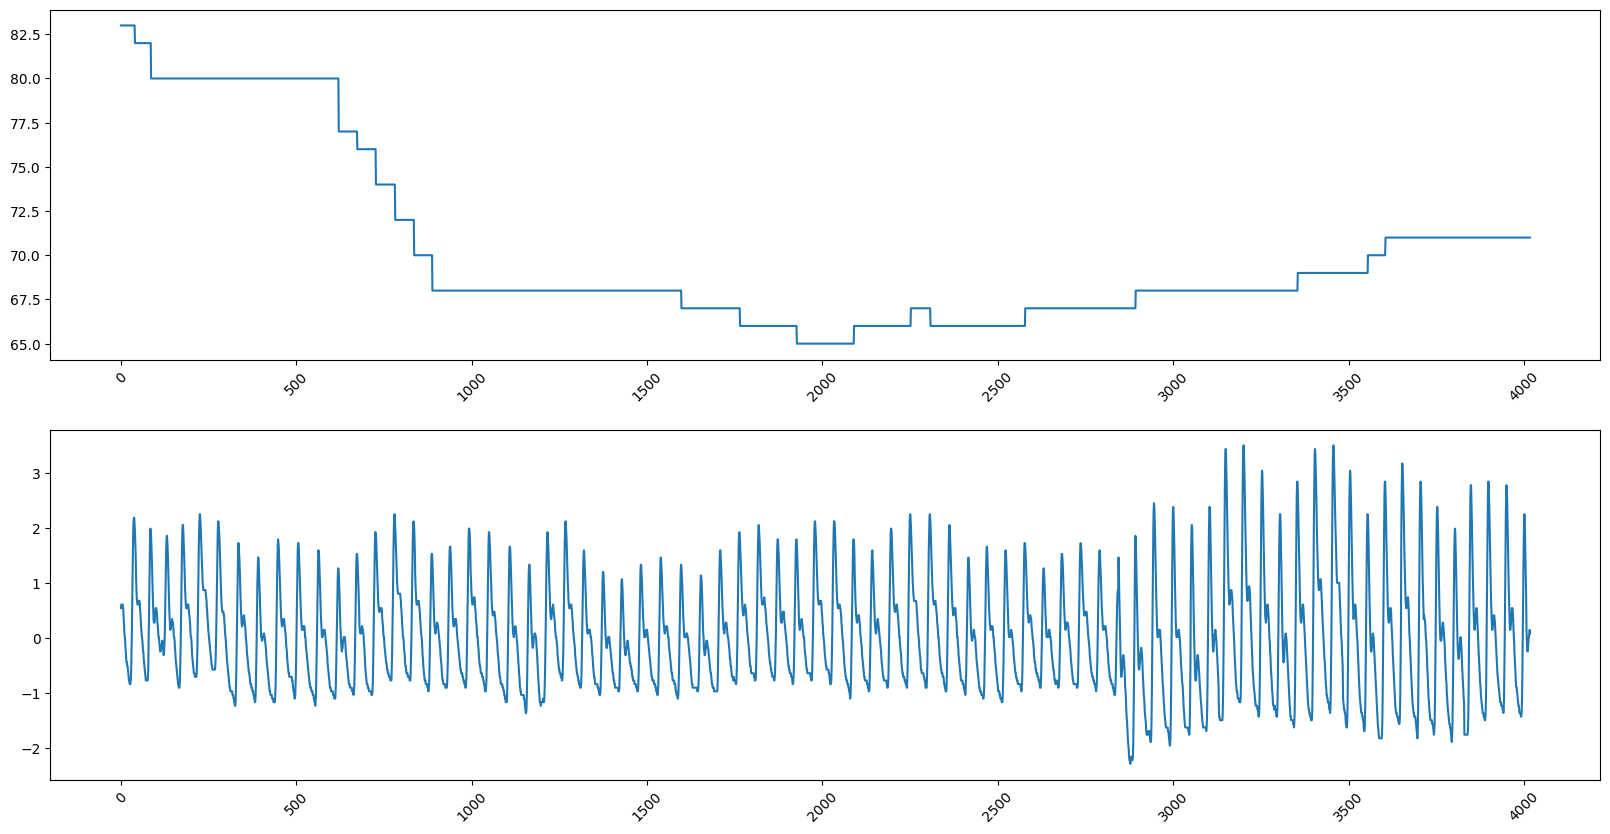

BPM = 70.12518666002987


In [16]:
import json 

gt_path = dataset_path + subject_name +'/01-01.json'

with open (gt_path, 'r') as file:
    data = json.load(file)

full_package_data = data["/FullPackage"]
image_data = data["/Image"]

timestamps_package = [entry["Timestamp"] for entry in full_package_data]
waveform = [entry["Value"]["waveform"] for entry in full_package_data]
pulseRate = [entry["Value"]["pulseRate"] for entry in full_package_data]
frame_package = [entry["FrameID"] for entry in full_package_data]
waveform = (waveform-np.mean(waveform))/np.std(waveform)

print(timestamps_package[:5])

## Converting Timestamps
# formatted_times_package = []
# for ts in timestamps_package:
#     # Convert nanoseconds to seconds
#     timestamp_sec = int(ts) / 1e9
    
#     # Create a datetime object for the integer part of the timestamp
#     time = dt.datetime.fromtimestamp(timestamp_sec)
    
#     # Get the fractional seconds (2 decimal places)
#     fractional_sec = f"{timestamp_sec % 60:.2f}"
    
#     # Combine the minute and second part from the datetime object with fractional seconds
#     formatted_time = time.strftime("%M:%S") + fractional_sec[2:]  # Skip leading '0' in fractional seconds
#     formatted_times_package.append(formatted_time)

# formatted_times_package = sorted(formatted_times_package)




# print(formatted_times_package[:5])
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(pulseRate)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability

plt.subplot(2,1,2)
plt.plot(waveform)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

##plotting against converted timestamps
# # Plot pulse rate
# plt.subplot(2, 1, 1)
# plt.plot(filtered_times, filtered_pulseRate)
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set number of x-ticks to 10
# plt.xticks(rotation=45)  # Rotate labels for better readability
# plt.title("Pulse Rate")

# # Plot waveform
# plt.subplot(2, 1, 2)
# plt.plot(filtered_times, filtered_waveform)
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set number of x-ticks to 10
# plt.xticks(rotation=45)  # Rotate labels for better readability
# plt.title("Waveform")
# plt.show()

print(f"BPM = {np.mean(pulseRate)}")
# print(len(timestamps_package))
# print(len(frame_package))
# print(len(timestamps))
# print(len(frame))

Estimate BPM

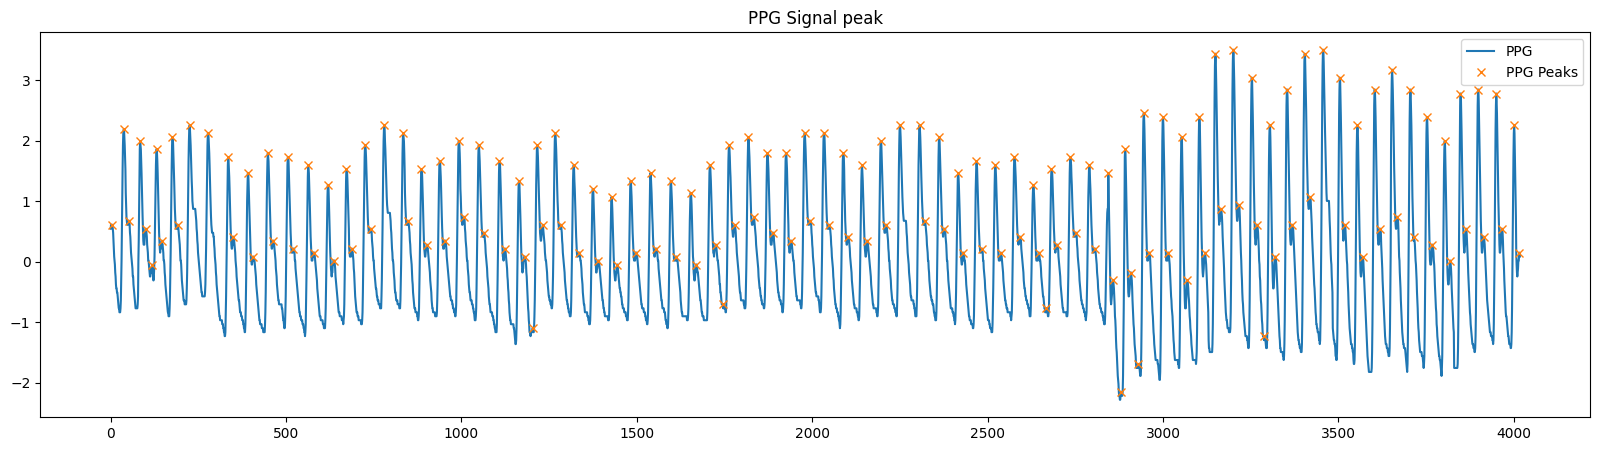

PPG Peaks = 155


In [17]:
from scipy.signal import find_peaks
PPG_peaks, _ = find_peaks(waveform)

plt.figure(figsize=(20,5))
plt.plot(waveform, label='PPG')
plt.plot(PPG_peaks, waveform[PPG_peaks], "x", label='PPG Peaks')
plt.legend()
plt.title("PPG Signal peak")
plt.show()

print(f"PPG Peaks = {len(PPG_peaks)}")

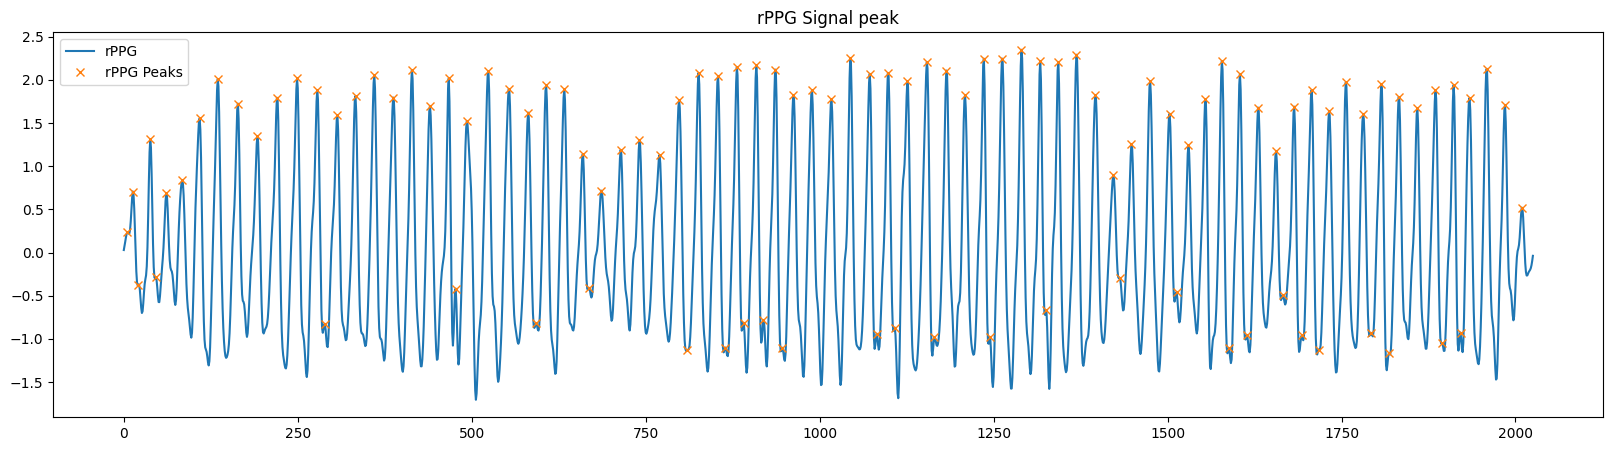

rPPG Peaks = 104


In [18]:
from scipy.signal import find_peaks
rPPG_peaks, _ = find_peaks(rPPG_filtered)

plt.figure(figsize=(20,5))
plt.plot(rPPG_filtered, label='rPPG')
plt.plot(rPPG_peaks, rPPG_filtered[rPPG_peaks], "x", label='rPPG Peaks')
plt.legend()
plt.title("rPPG Signal peak")
plt.show()

print(f"rPPG Peaks = {len(rPPG_peaks[:300])}")

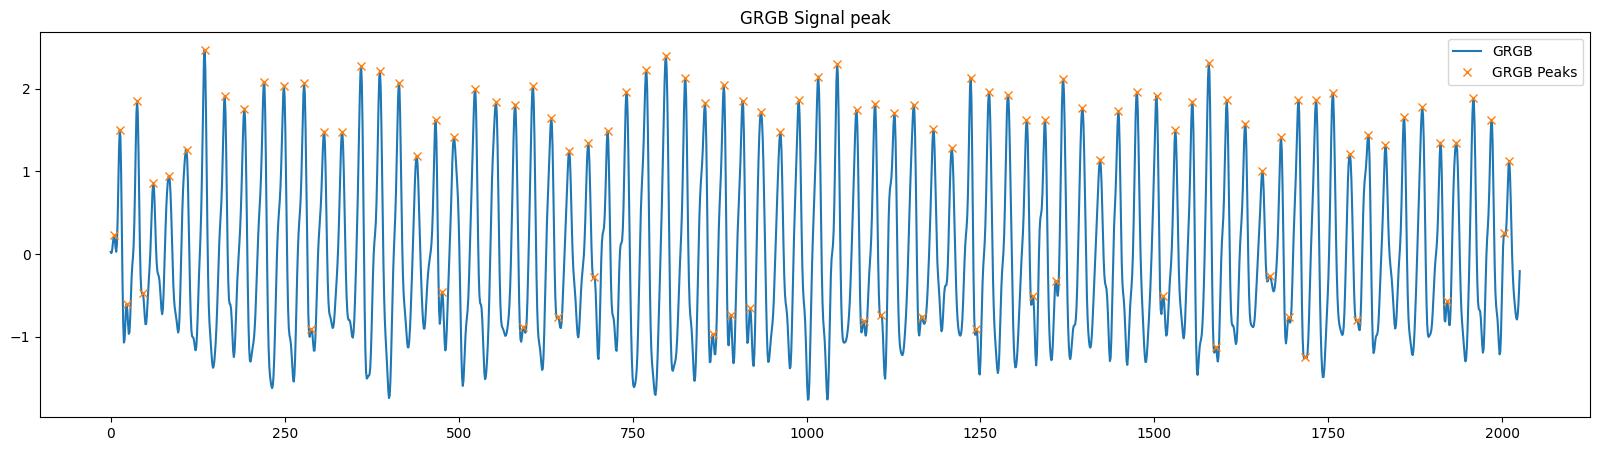

GRGB Peaks = 101


In [19]:
from scipy.signal import find_peaks
GRGB_peaks, _ = find_peaks(GRGB_filtered)

plt.figure(figsize=(20,5))
plt.plot(GRGB_filtered, label='GRGB')
plt.plot(GRGB_peaks, GRGB_filtered[GRGB_peaks], "x", label='GRGB Peaks')
plt.legend()
plt.title("GRGB Signal peak")
plt.show()

print(f"GRGB Peaks = {len(GRGB_peaks)}")

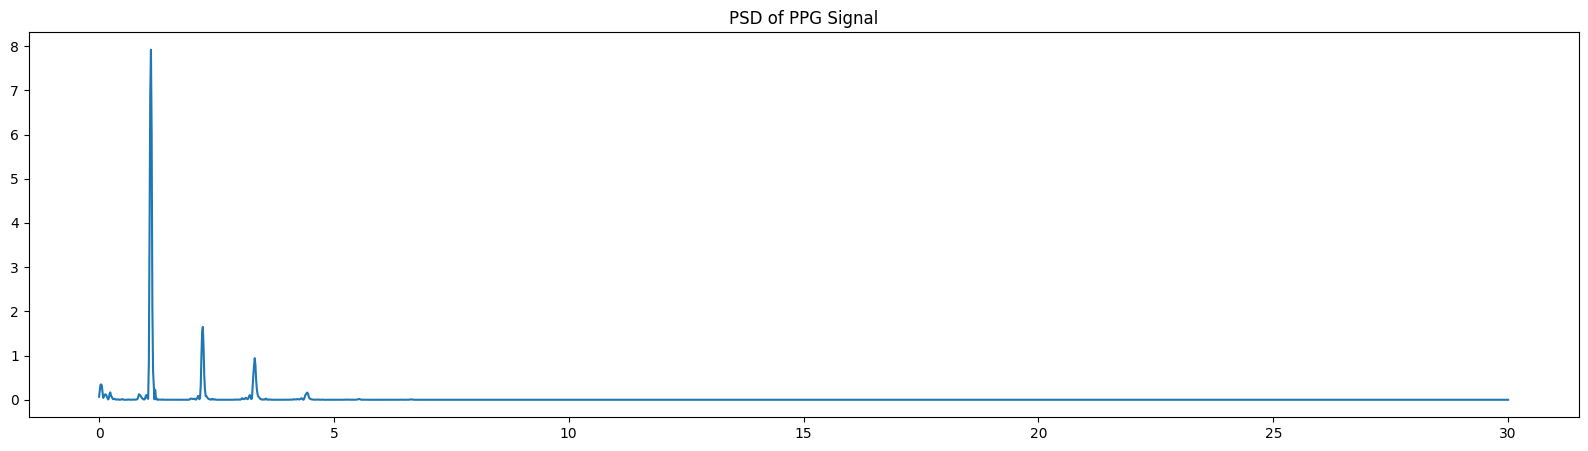

Max Frequency of PPG Signal: 1.1050273768043803
BPM: 66.30164260826282


In [29]:
from scipy.signal import welch

seg_len = (2*waveform.shape[0]) // n_segment + 1

freq_PPG, psd_PPG = welch(waveform, fs=60, nperseg=seg_len, window='flattop')

plt.figure(figsize=(20,5))
plt.plot(freq_PPG, psd_PPG)
plt.title("PSD of PPG Signal")
plt.show()

max_freq_PPG =  freq_PPG[np.argmax(psd_PPG)]
print(f"Max Frequency of PPG Signal: {max_freq_PPG}")
PPG_bpm = max_freq_PPG * 60
print(f"BPM: {PPG_bpm}")

C:\Users\Darren\AppData\Roaming\Python\Python311\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 2027 is greater than input length  = 2026, using nperseg = 2026
  warnings.warn('nperseg = {0:d} is greater than input length '


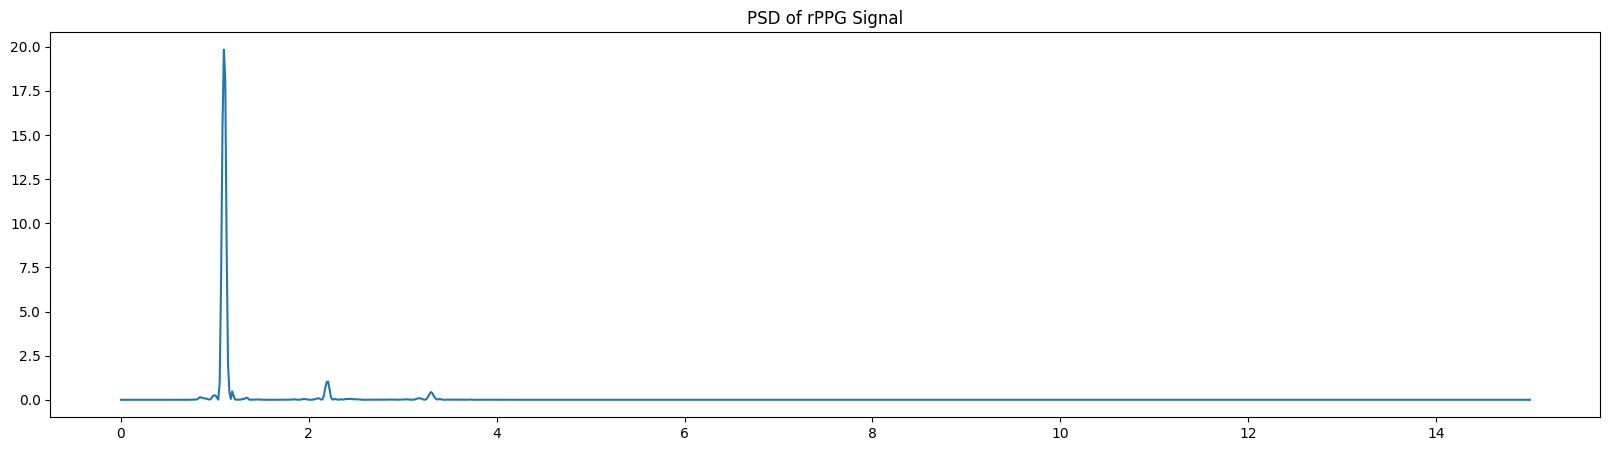

Max Frequency of rPPG Signal: 1.0957551826258638
BPM: 65.74531095755182


In [30]:
from scipy.signal import welch

seg_len = (2*rPPG_filtered.shape[0]) // n_segment + 1

freq_rPPG, psd_rPPG = welch(rPPG_filtered, fs=fps, nperseg=seg_len, window='flattop')

plt.figure(figsize=(20,5))
plt.plot(freq_rPPG, psd_rPPG)
plt.title("PSD of rPPG Signal")
plt.show()

max_freq_rPPG =  freq_rPPG[np.argmax(psd_rPPG)]
print(f"Max Frequency of rPPG Signal: {max_freq_rPPG}")
rPPG_bpm = max_freq_rPPG * 60
print(f"BPM: {rPPG_bpm}")

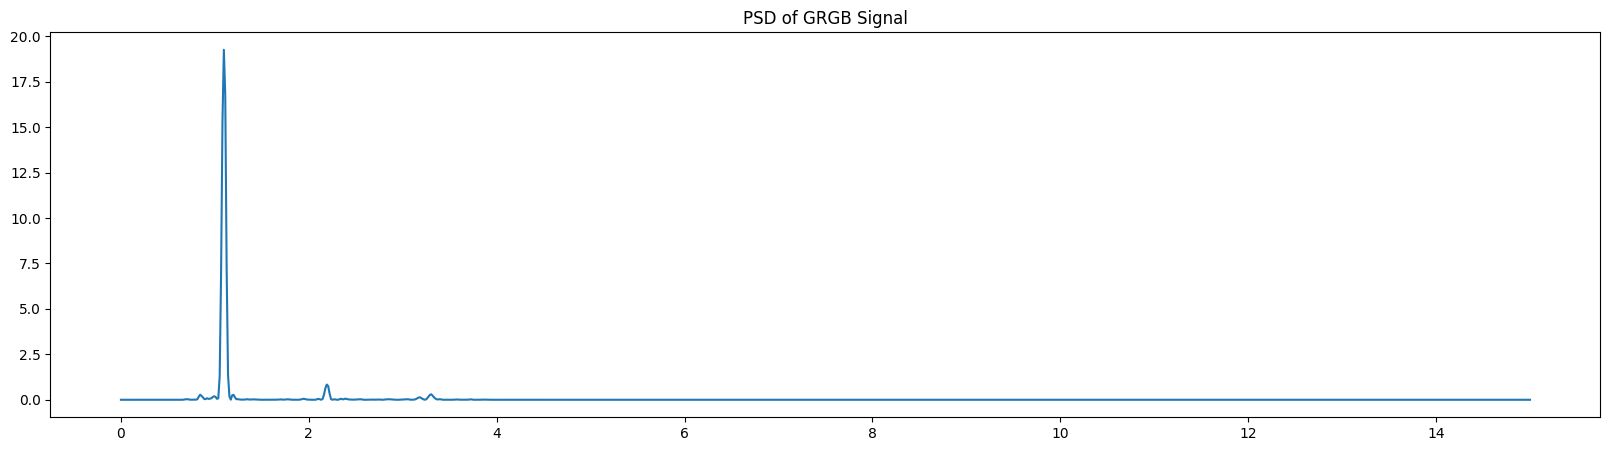

Max Frequency of GRGB Signal: 1.0957551826258638
BPM: 65.74531095755182


In [22]:
from scipy.signal import welch

seg_len = (2*GRGB_filtered.shape[0]) // n_segment + 1

freq_GRGB, psd_GRGB = welch(GRGB_filtered, fs=fps, nperseg=seg_len, window='flattop')

plt.figure(figsize=(20,5))
plt.plot(freq_GRGB, psd_GRGB)
plt.title("PSD of GRGB Signal")
plt.show()

max_freq_GRGB =  freq_GRGB[np.argmax(psd_GRGB)]
print(f"Max Frequency of GRGB Signal: {max_freq_GRGB}")
GRGB_bpm = max_freq_GRGB * 60
print(f"BPM: {GRGB_bpm}")

In [45]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import pandas as pd

# 1. Error Metrics (MAE, RMSE, PCC) for heart rate comparison
def evaluate_hr_metrics(ppg_bpm, rppg_bpm):
    # Ensure both sequences are the same length
    ppg_bpm = np.array(ppg_bpm)
    rppg_bpm = np.array(rppg_bpm)
    
    # Compute error metrics
    mae = mean_absolute_error(ppg_bpm, rppg_bpm)
    rmse = np.sqrt(mean_squared_error(ppg_bpm, rppg_bpm))
    pcc, _ = pearsonr(ppg_bpm, rppg_bpm)
    
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Square Error (RMSE): {rmse}")
    print(f"Pearson Correlation Coefficient (PCC): {pcc}")
    
    return mae, rmse, pcc

# 2. Load your dataset (assuming it's saved as an .xlsx file)
# Replace 'your_dataset.xlsx' with the path to your actual Excel file
df = pd.read_excel('rPPG_Testing_PURE.xlsx')

# Extract columns: BPM FFT (oxy) for ground truth and POS BPM (YCrCb) for rPPG estimation
oxy_bpm = df['BPM FFT (oxy)']
rppg_bpm = df['POS BPM (YCrCb)']

# 3. Evaluate the metrics
mae, rmse, pcc = evaluate_hr_metrics(oxy_bpm, rppg_bpm)

# Optional: Print the first few rows to confirm
# print(df)


Mean Absolute Error (MAE): 0.7191457016850102
Root Mean Square Error (RMSE): 1.029175150431185
Pearson Correlation Coefficient (PCC): 0.9994582718758561


In [57]:
def calculate_accuracy(ppg_bpm, rppg_bpm, threshold):
    ppg_bpm = np.array(ppg_bpm)
    rppg_bpm = np.array(rppg_bpm)

    # Count correct predictions within the threshold
    correct_predictions = np.sum(np.abs(ppg_bpm - rppg_bpm) <= threshold)
    accuracy = (correct_predictions / len(ppg_bpm)) * 100
    
    return accuracy

threshold = 2
accuracy = calculate_accuracy(oxy_bpm, rppg_bpm, threshold)
print(f"Accuracy (within {threshold} BPM): {accuracy:.2f}%")

Accuracy (within 2 BPM): 96.61%


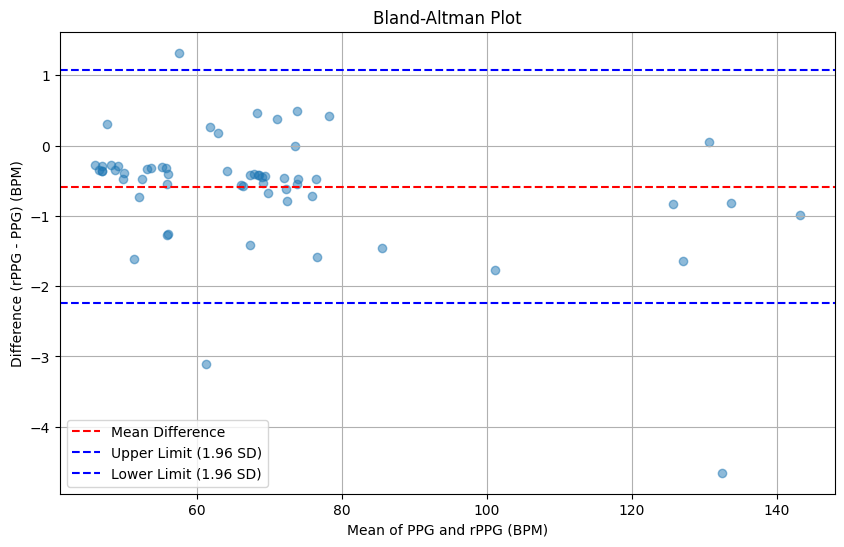

In [49]:
def bland_altman_plot(ppg_bpm, rppg_bpm):
    ppg_bpm = np.array(ppg_bpm)
    rppg_bpm = np.array(rppg_bpm)
    
    # Calculate the mean and difference
    mean_values = (ppg_bpm + rppg_bpm) / 2
    diff_values = rppg_bpm - ppg_bpm
    
    # Calculate mean and standard deviation of differences
    mean_diff = np.mean(diff_values)
    std_diff = np.std(diff_values)
    
    # Create Bland-Altman plot
    plt.figure(figsize=(10, 6))
    plt.scatter(mean_values, diff_values, alpha=0.5)
    plt.axhline(mean_diff, color='red', linestyle='--', label='Mean Difference')
    plt.axhline(mean_diff + 1.96 * std_diff, color='blue', linestyle='--', label='Upper Limit (1.96 SD)')
    plt.axhline(mean_diff - 1.96 * std_diff, color='blue', linestyle='--', label='Lower Limit (1.96 SD)')
    
    plt.title('Bland-Altman Plot')
    plt.xlabel('Mean of PPG and rPPG (BPM)')
    plt.ylabel('Difference (rPPG - PPG) (BPM)')
    plt.legend()
    plt.grid()
    plt.show()

bland_altman_plot(oxy_bpm, rppg_bpm)